# Some simple fun playing with noise statistics

Example notebook that is characterising the noise in a bandlimited amplified system.

In [1]:
from PyScopeTools import PyScopeTools as pst
from PyFFTTools import PyFFTTools as pft
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.signal import savgol_filter
import matplotlib.style
import matplotlib as mpl
import math
import scipy.fftpack
from scipy.signal import butter,filtfilt

# Import the curve_fit function
from scipy.optimize import curve_fit

#Set default figure size
mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams["legend.frameon"] = False
mpl.rcParams.update({'font.size': 22})

In [2]:
def getDataSet(fileNameBase):
    amplifiedNoiseList,timeList=pst.getScopeWaveforms(fileNameBase+".ch1.traces",True)
    justSineList,_=pst.getScopeWaveforms(fileNameBase+".ch3.traces",True)
    dt=timeList[1]-timeList[0]
    fs=1./dt
    return amplifiedNoiseList,justSineList,timeList,dt,fs
#amplifiedNoiseList,justSineList,timeList,dt,fs=getDataSet("/Users/rjn/qtnm/data/justNoise/nosine_long_highpass")
amplifiedNoiseList,justSineList,timeList,dt,fs=getDataSet("/Users/rjn/qtnm/data/justNoise/nosine_superlong_highpass")
#amplifiedNoiseList,justSineList,timeList,dt,fs=getDataSet("/Users/rjn/qtnm/data/amplifiedNoise/ANine_300MHz_500mV_long_highpass")

print(dt,timeList[-1]-timeList[0])
print(timeList.shape)
print(amplifiedNoiseList.shape)

def zeroMeanWaveform(waveList):
   return waveList- np.mean(waveList,axis=1)[:,None]  #Need the [:,None] to expand 1D array to 2D array


N=50002#
justSineList=justSineList[:,0:N]
amplifiedNoiseList=amplifiedNoiseList[:,0:N]
timeList=timeList[0:N]

justSineList=zeroMeanWaveform(justSineList)
amplifiedNoiseList=zeroMeanWaveform(amplifiedNoiseList)



Found 10000 waveforms with 400002 samples
Found 10000 waveforms with 400002 samples
5.000000066779364e-05 20.00005026702931
(400002,)
(10000, 400002)


0.010895330498163136 0.010895330498163136


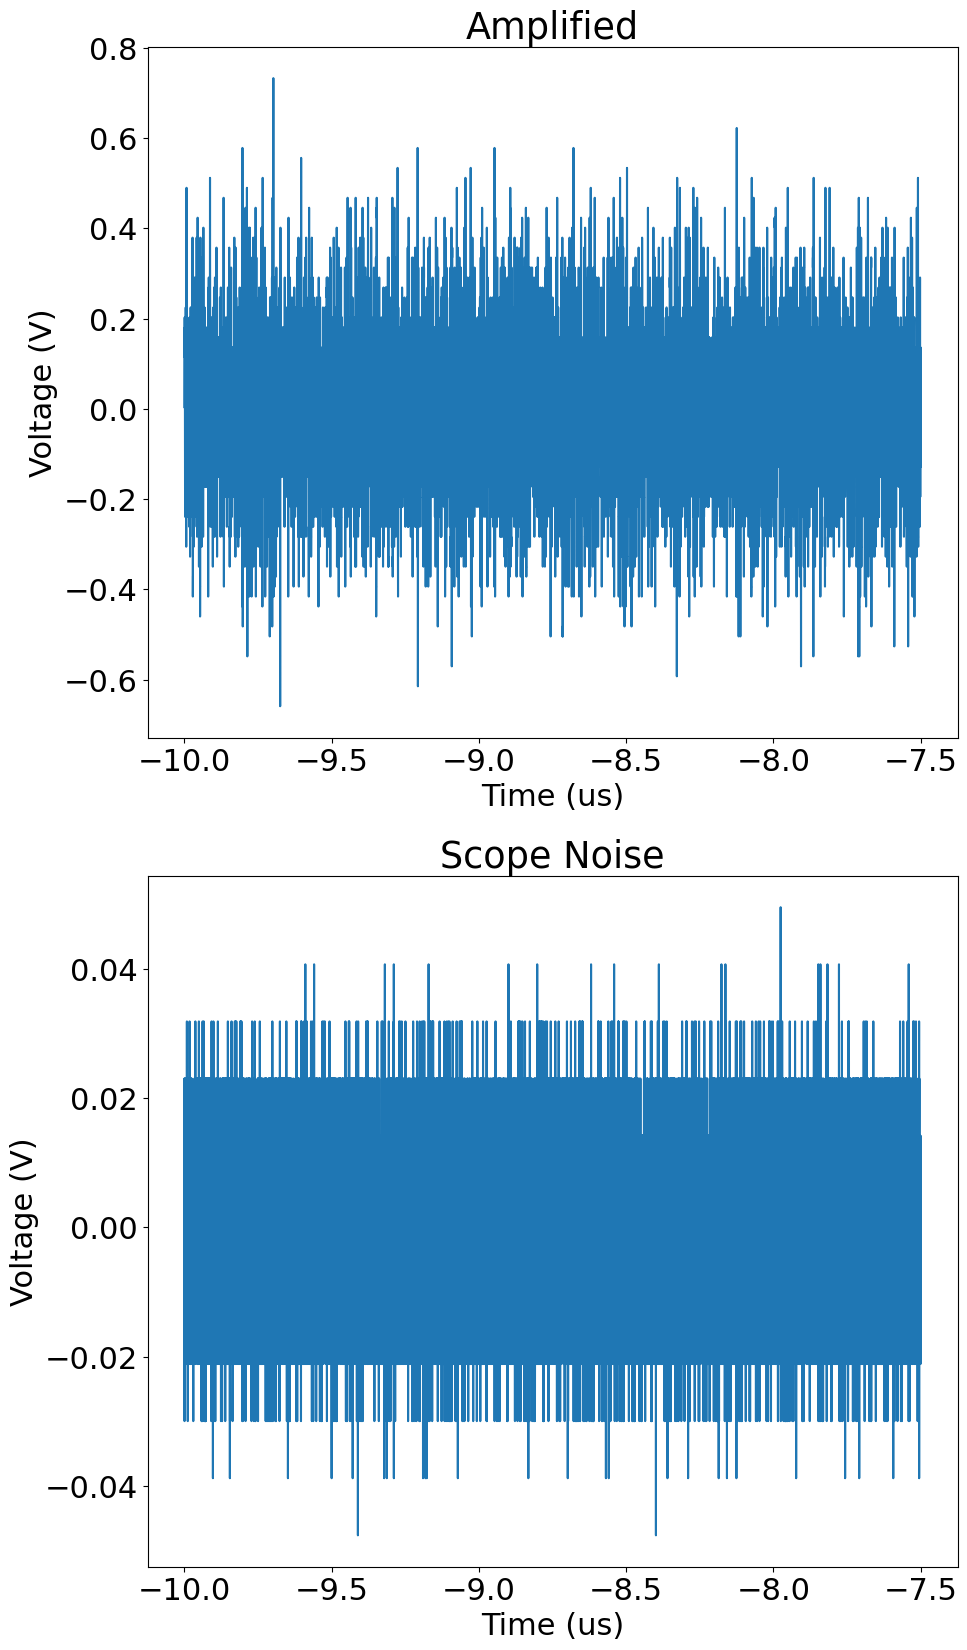

In [3]:
#Plot the raw and smoothed waveforms
fig, ax = plt.subplots(2,1)
ax[0].plot(timeList,amplifiedNoiseList[0],label="Raw")
ax[0].set_xlabel('Time (us)')
ax[0].set_ylabel('Voltage (V)')
ax[0].set_title('Amplified')    
#ax[0].legend(fontsize=20,loc='upper right')

print(np.std(justSineList[0]),np.sqrt(np.mean(justSineList[0]**2)))
ax[1].plot(timeList,justSineList[0],label="Raw")
ax[1].set_xlabel('Time (us)')
ax[1].set_ylabel('Voltage (V)')
ax[1].set_title('Scope Noise')
#ax[1].legend(fontsize=20,loc='upper right')
plt.subplots_adjust(bottom=0.1, right=0.8, top=2)

RMS 0.16644624323470109


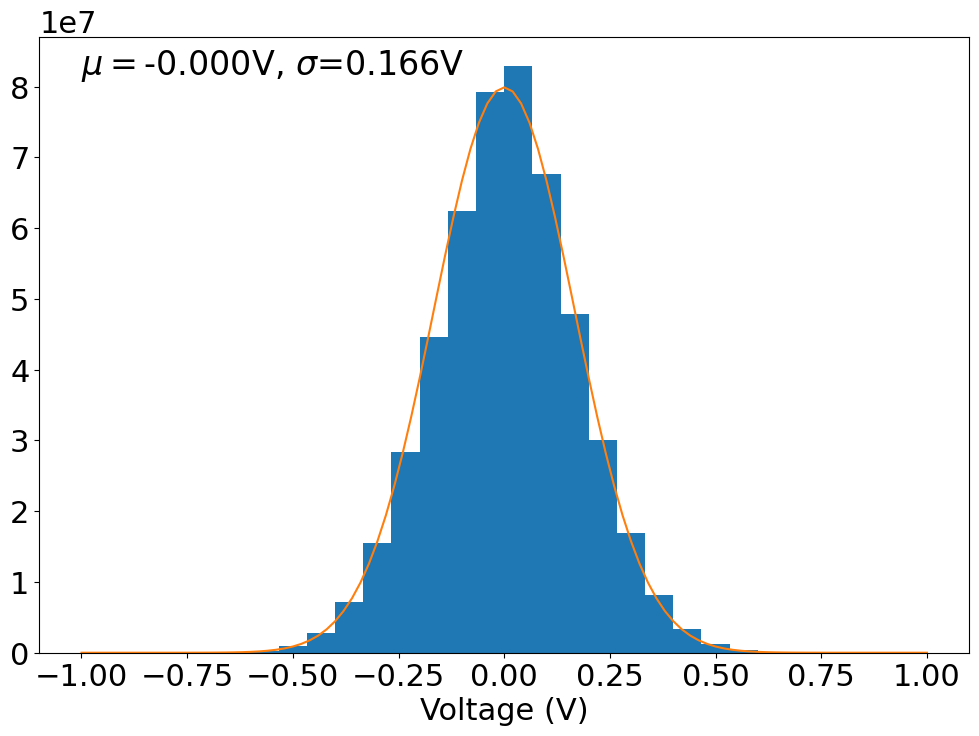

In [4]:
nbins=30
fig,ax =plt.subplots()
counts, bins, _ = ax.hist(amplifiedNoiseList.flatten(),bins=np.linspace(-1,1,nbins+1))
ax.set_xlabel("Voltage (V)")
text_kwargs = dict(ha='left', va='center', fontsize=24, color='Black')
mu=np.mean(amplifiedNoiseList.flatten())
std=np.std(amplifiedNoiseList.flatten())
print("RMS",pft.getRMS(amplifiedNoiseList.flatten()))
N=len(amplifiedNoiseList.flatten())
stdLabel=r"$\mu=$%.3fV, $\sigma$=%.3fV" % (mu,std)
ax.text(-1,np.max(counts),stdLabel,**text_kwargs )

from scipy.stats import norm
x=np.linspace(-1,1,101)
ax.plot(x,2*N*norm.pdf(x,mu,std)/nbins) #nbins for number of bins in histogram, 2 as it is from -1 to 1


flatNoiseList=np.random.normal(loc=mu,scale=std,size=amplifiedNoiseList.shape)

## Quick aside on Discrete Fourier Transforms

The accepted inclusive defintion of the Discrete Fourier transform of a sequence of $N$ complex numbers ${x_n} := x_0, x_1, \ldots, x_{N-1}$ which results in $N$ complex numbers ${X_k} := X_0, X_1, \ldots, X_{N-1}$ is:
$$ X_k  = \sum_{n=0}^{N-1} x_n e^{ \frac{- i 2 \pi k n}{N}} $$

The corresponding inverse transform is:
$$ x_n  = \frac{1}{N} \sum_{k=0}^{N-1} X_k e^{ \frac{+ i 2 \pi k n}{N}} $$

With this definition we have Parseval's theorem which relates the sum of the magntidues in the thing we will eventually call the time domain ($x_n$) and the one we will call frequency domain ($X_k$):
$$ \sum_{n=0}^{N-1} \left| x_n \right|^2 = \frac{1}{N} \sum_{k=0}^{N-1} \left| X_k \right|^2 $$


### Special case: Real input
Most of the time we are interested in the special case where the (time domain) input of the Fourier transform is real (e.g. the voltages in a voltage-time waveform from an oscilloscope). In this special case we find that the two halfs of the transform have a conjugation symmetry:
$$ X_{k}^* = X_{N-k+1} $$

For this case we only need to look at the first $N/2$ elements of the (frequency domain) transform to get all of the information since the other half of the transform is just the complex the conjugate. Here we need to be a little careful to assure that when we are reading numbers in the frequency domain they make physical sense.

The normalisation we use here is that we set the magnitude of the $k$th frequency bin $F_k$ as
$$F_k = \frac{\sqrt{2}}{N} \left| X_k \right|$$
where $k \in 0,1, \ldots,N/2$



#### Why this normalisation?
With this normalisation we can test our scaling by assuming that our samples are voltages. Then if we have a 1V RMS sine wave signal across a 1 Ohm resistor the power in the given frequency bin is 1W where
$$ P_k = \frac{F_k^2}{R} $$

So if we want $P_k$ in terms of the $X_k$ we have
$$ P_k = \frac{2}{R N^2} \left| X_k \right|^2 $$

Now if we compare this to Parseval's theorem above we can see the factor of 2 comes from only using the first $N/2$ frequency bins, whilst the extra factor of $N$ in the denominator is from the definiition of the root mean square of the voltages, $x_n$.
$$ P = \frac{<V^2>}{R} = \sum_{n=0}^{N-1} \frac{1}{N} \frac{x_n^2}{R} = \sum_{k=0}^{(N/2) -1}  \frac{2}{R N^2} \left| X_k \right|^2 $$




In [5]:
N=np.shape(amplifiedNoiseList[0])[0]
dt=timeList[1]-timeList[0]

from scipy.fft import fft, ifft  # Import the fft and inverse fft functions
yAN1 = fft(amplifiedNoiseList[0]) #FFT of Amplified Noise
yJS1 = fft(justSineList[0]) #FFT of Scope Noise
df=1/(N*dt)  # Frequency spacing
xf = pft.getFrequencyBins(N,dt) *1e6



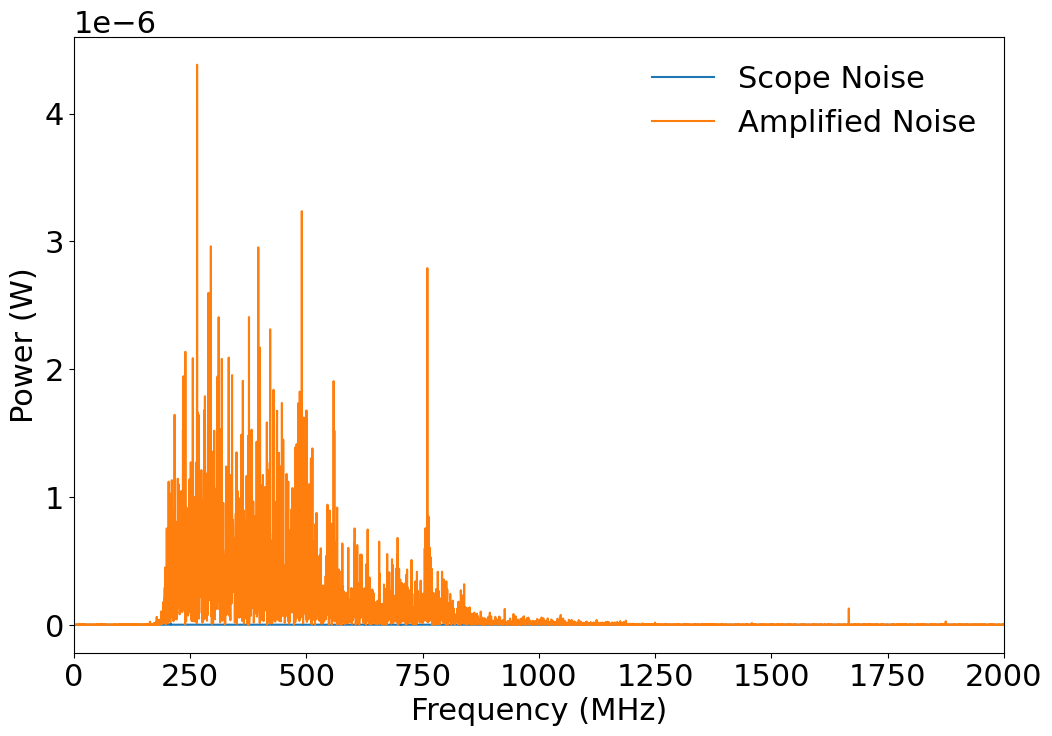

In [6]:
#Plot the frequency around the centre frequency bin
fig,ax = plt.subplots()
ax.plot(xf/1e6,pft.convertFFTToPower(yJS1,50),label="Scope Noise")  #1e6 to convert to MHz
ax.plot(xf/1e6,pft.convertFFTToPower(yAN1,50),label="Amplified Noise") #1e6 to convert to MHz
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Power (W)")
ax.set_xlim([0,2e3])
ax.legend()

(10000, 50002)
(50002,)


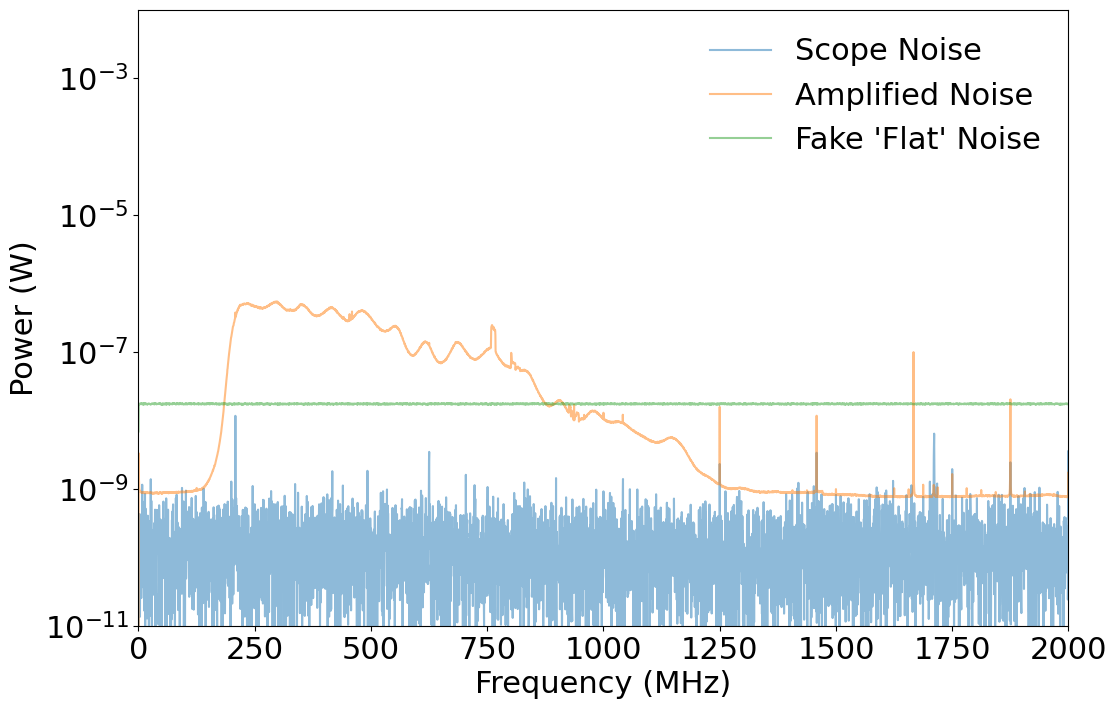

In [7]:
yAN = fft(amplifiedNoiseList) #FFT of Amplified Noise
yFN = fft(flatNoiseList)
print(yAN.shape)

yANMean=np.mean(np.abs(yAN),axis=0)
yFNMean=np.mean(np.abs(yFN),axis=0)
print(yANMean.shape)

fig,ax = plt.subplots()
ax.plot(xf/1e6,pft.convertFFTToPower(yJS1,50),label="Scope Noise",alpha=0.5)  #1e6 to convert to MHz
ax.plot(xf/1e6,pft.convertFFTToPower(yANMean,50),label="Amplified Noise",alpha=0.5) #1e6 to convert to MHz
ax.plot(xf/1e6,pft.convertFFTToPower(yFNMean,50),label="Fake 'Flat' Noise",alpha=0.5) #1e6 to convert to MHz
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel(r"Power (W)")
ax.set_yscale('log')
ax.set_ylim([1e-11,1e-2])
ax.set_xlim([0,2e3])
ax.legend()

#guessFreq=xf[np.argmax(convertToMag(yANMean))]
#print(guessFreq)


Total Power (amplified noise) 0.00043462257790492835 W
Total Power (amplified noise) -3.618877165685766 dBm
Total Power (fake flat noise) 0.0004351843362429145 W
Total Power (fake flat noise) -3.613267447567801 dBm
RMS(amplified noise) 0.1637158888184928
Power(amplified noise) 0.0005360578450325819 W
Power(amplified noise) -2.7078834384643846 dBm
Maximum P_JS(dbm): -47.93214488656022 dBm
Maximum P_NS(dbm): -32.65043947192491 dBm
Total P_NS(dbm): -3.618877165685766 dBm
Thermal Noise (dbM) full band: -3.1535261982572393
Thermal Noise (dbM) single bin: -31.904312604496553 df= 399983.99529783893 Hz
Thermal Noise (dbM) 1 Hz: -87.92473874545385
Indices of 200MHz and 300MHz 500 750
Real Noise Power at 300MHz 5.275120931569428e-07 W
Real Noise Power at 200MHz 1.7222588779137694e-07 W
Flat Noise Power at 300MHz 1.762472525851714e-08 W
Flat Noise Power at 200MHz 1.7284797086194765e-08 W
Thermal Noise (W) single bin: 6.45013403648792e-07 df= 399983.99529783893 Hz


<function PyFFTTools.PyFFTTools.convertdBmtoPower(P)>

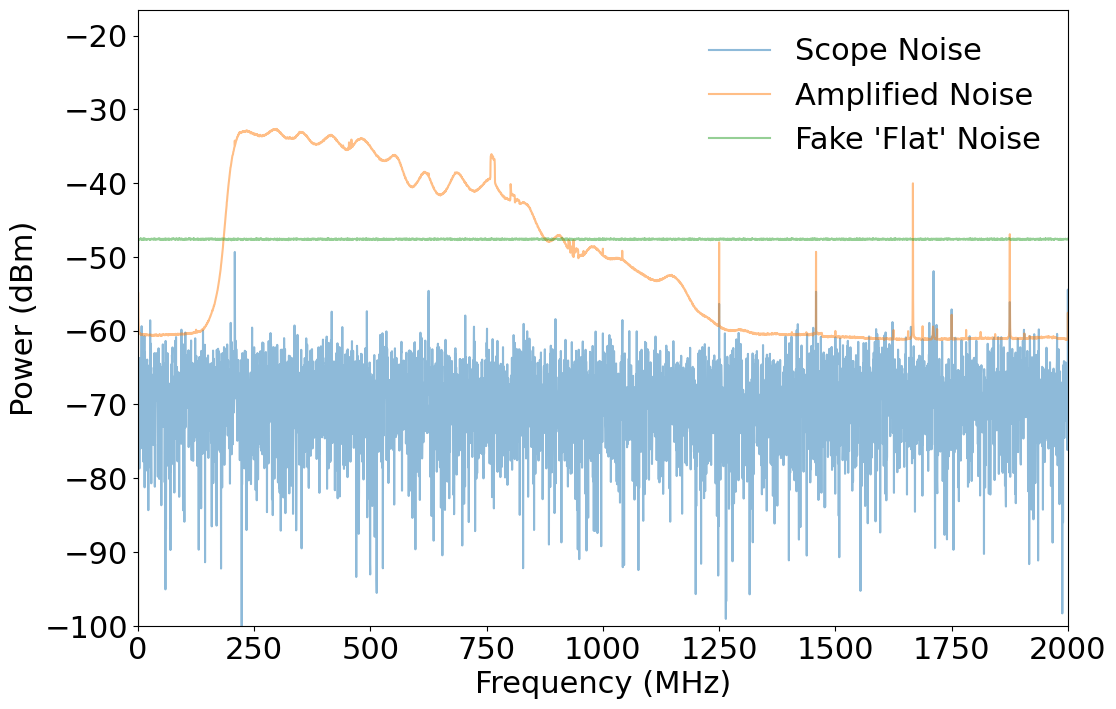

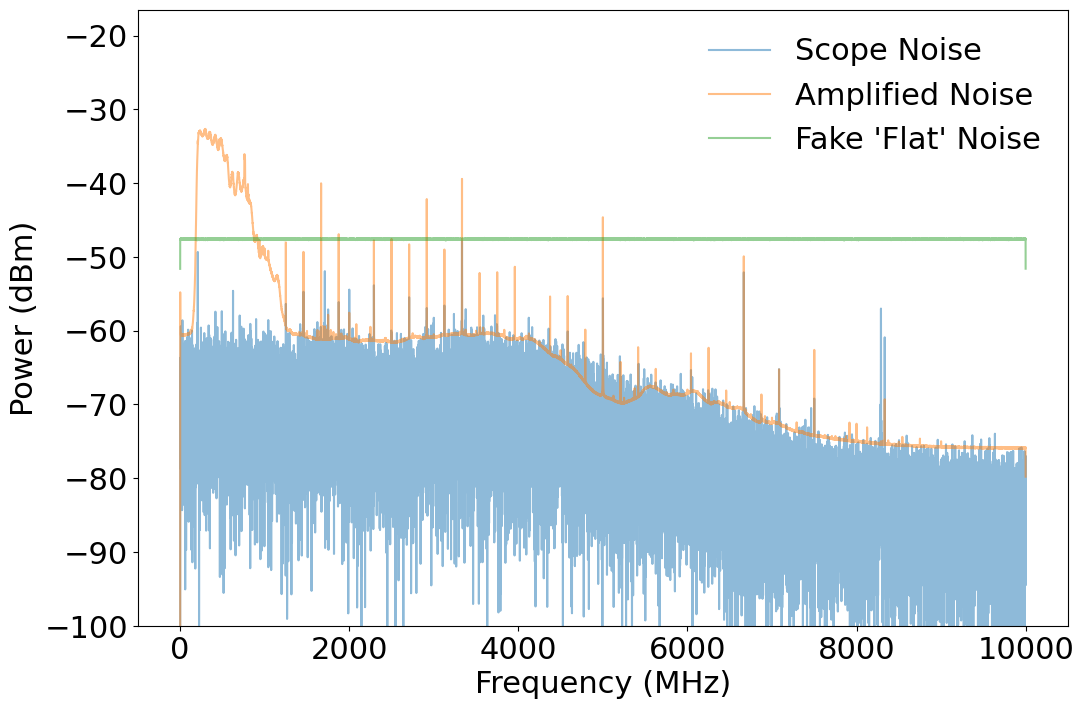

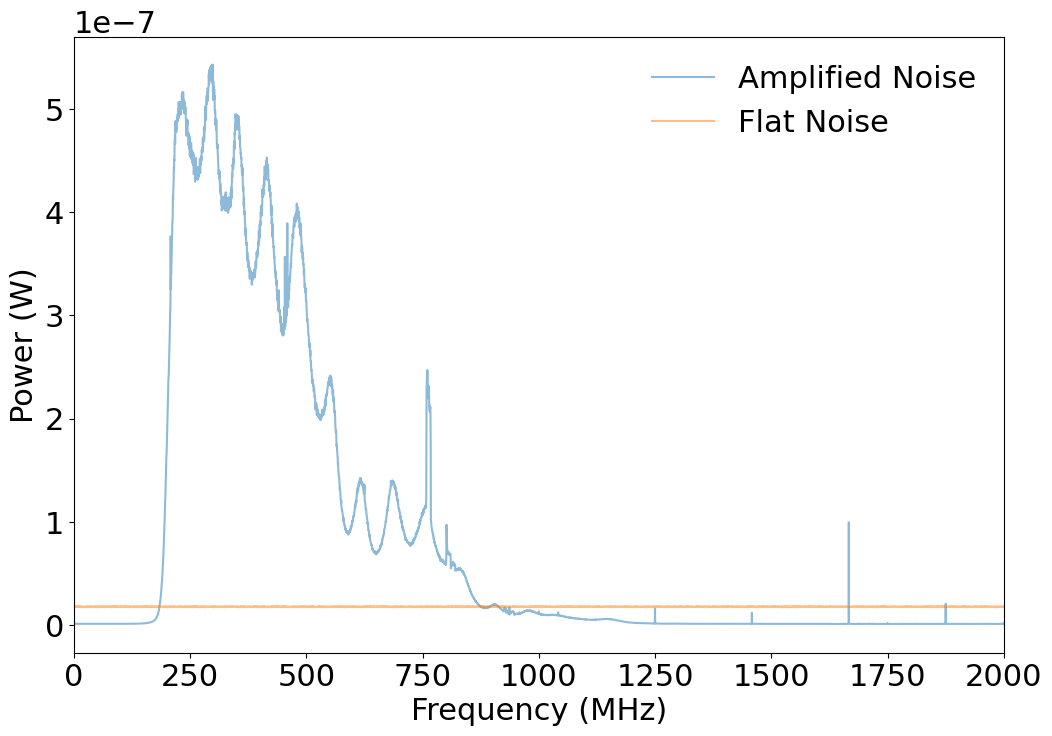

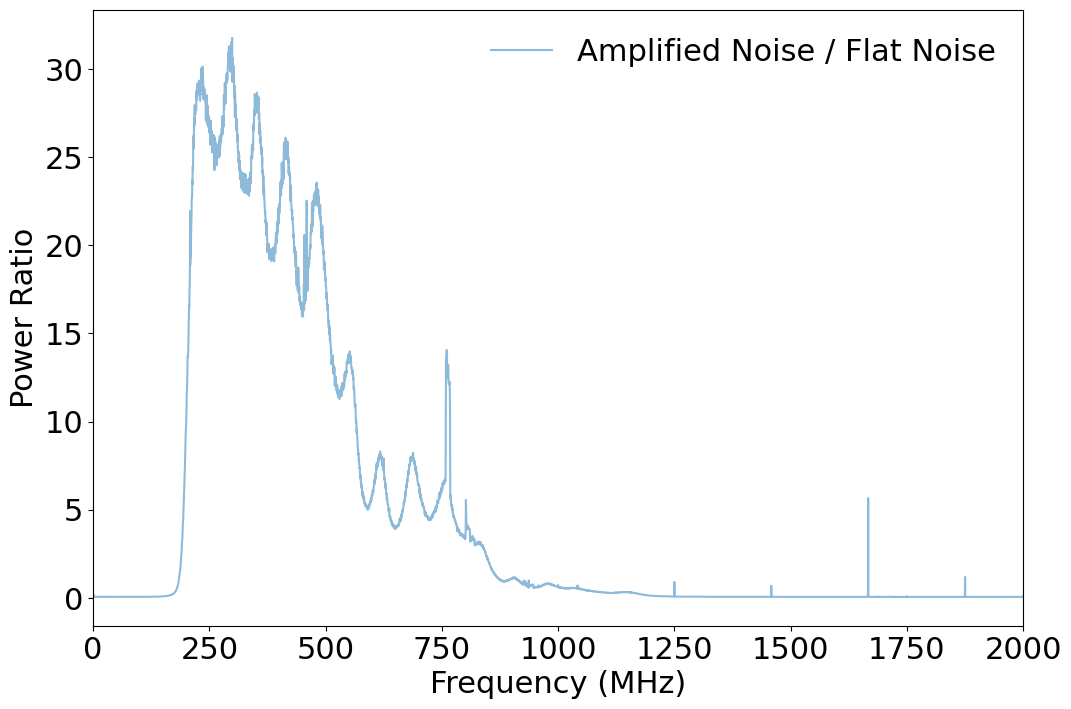

In [30]:
fig,ax = plt.subplots()
ax.plot(xf/1e6,pft.convertFFTTodBm(yJS1),label="Scope Noise",alpha=0.5)
ax.plot(xf/1e6,pft.convertFFTTodBm(yANMean,50),label="Amplified Noise",alpha=0.5) #1e6 to convert to MHz
ax.plot(xf/1e6,pft.convertFFTTodBm(yFNMean,50),label="Fake 'Flat' Noise",alpha=0.5) #1e6 to convert to MHz
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Power (dBm)")
#ax.set_yscale('log')
low,high=ax.get_ylim()
ax.set_ylim([-100,high])
ax.set_xlim([0,2e3])
ax.legend()



fig,ax = plt.subplots()
ax.plot(xf/1e6,pft.convertFFTTodBm(yJS1),label="Scope Noise",alpha=0.5)
ax.plot(xf/1e6,pft.convertFFTTodBm(yANMean,50),label="Amplified Noise",alpha=0.5) #1e6 to convert to MHz
ax.plot(xf/1e6,pft.convertFFTTodBm(yFNMean,50),label="Fake 'Flat' Noise",alpha=0.5) #1e6 to convert to MHz
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Power (dBm)")
#ax.set_yscale('log')
low,high=ax.get_ylim()
ax.set_ylim([-100,high])
ax.legend()




fig,ax = plt.subplots()
ax.plot(xf/1e6,pft.convertFFTToPower(yANMean,50),label="Amplified Noise",alpha=0.5) #1e6 to convert to MHz
ax.plot(xf/1e6,pft.convertFFTToPower(yFNMean,50),label="Flat Noise",alpha=0.5) #1e6 to convert to MHz
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Power (W)")
#ax.set_yscale('log')
#low,high=ax.get_ylim()
#ax.set_ylim([-100,high])
ax.set_xlim([0,2e3])
ax.legend()

fig,ax = plt.subplots()
ax.plot(xf/1e6,pft.convertFFTToPower(yANMean,50)/pft.convertFFTToPower(yFNMean,50),label="Amplified Noise / Flat Noise",alpha=0.5) #1e6 to convert to MHz
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Power Ratio")
#ax.set_yscale('log')
#low,high=ax.get_ylim()
#ax.set_ylim([-100,high])
ax.set_xlim([0,2e3])
ax.legend()

#These three only make sense for a single tone
print("Total Power (amplified noise)",np.sum(pft.convertFFTToPower(yANMean,50)),"W")
print("Total Power (amplified noise)",pft.convertPowerTodBm(np.sum(pft.convertFFTToPower(yANMean,50))),"dBm")
print("Total Power (fake flat noise)",np.sum(pft.convertFFTToPower(yFNMean,50)),"W")
print("Total Power (fake flat noise)",pft.convertPowerTodBm(np.sum(pft.convertFFTToPower(yFNMean,50))),"dBm")
print('RMS(amplified noise)',pft.getRMS(amplifiedNoiseList[0]))
print('Power(amplified noise)',pft.getRMS(amplifiedNoiseList[0])**2/50,"W")
print('Power(amplified noise)',pft.convertPowerTodBm(pft.getRMS(amplifiedNoiseList[0])**2/50),"dBm")
#print("RMS(justSineList[0]):",getRMS(justSineList[0]),"V")
#print("Power(justSineList[0]):",getRMS(justSineList[0])**2/50,"W")
#print("Power(justSineList[0]):",convertPowerTodBm(getRMS(justSineList[0])**2/50),"dBm")
print("Maximum P_JS(dbm):",np.max(pft.convertFFTTodBm(yJS1,50)),"dBm")
print("Maximum P_NS(dbm):",pft.convertPowerTodBm(np.max(pft.convertFFTToPower(yANMean,50))),"dBm")
print("Total P_NS(dbm):",pft.convertPowerTodBm(np.sum(pft.convertFFTToPower(yANMean,50))),"dBm")

#print("500mV @ 50Ohm",convertPowerTodBm(0.5**2/50),"dBm")
#print("500mV/sqrt(2) @ 50Ohm",convertPowerTodBm(0.5**2/(np.sqrt(2)*50)),"dBm")

#print(convertPowerTodBm(convertToPower(yANMean,50))[0:100])
pDbm=pft.convertPowerTodBm(pft.convertFFTToPower(yANMean,50))
def guessBandwidth(pDBm,xf):
    i=np.argmax(pDBm)
    print(pDbm[i])
    #Check for 3dB point
    arg = np.where(pDBm>(pDBm[i]-3))[0]
    
    #Now check for contiguous points
    diff=arg[1:]-arg[:-1]
    arg2=np.where(diff==1)[0]
    diff2=np.where(arg2[1:]-arg2[:-1])[0]
    low=arg[0]+diff2[0]
    high=arg[0]+diff2[-1]
    
    return (xf[low],xf[high])
#
#bw=guessBandwidth(pDbm,xf)
#print(bw,bw[1]-bw[0])

bandwidth=300e6#(bw[1]-bw[0])*1e6


def getGainFromNoiseRMS(vrms,T,R,df):
    noiseRMS=PyFFTTools.getNoiseRMS(T,R,df)
    return 20*np.log10(vrms/noiseRMS)
gainIndB=80 #db 
print("Thermal Noise (dbM) full band:",gainIndB+pft.convertPowerTodBm(pft.getNoiseRMS(292,50,bandwidth)**2/50))
print("Thermal Noise (dbM) single bin:",gainIndB+pft.convertPowerTodBm(pft.getNoiseRMS(292,50,(xf[1]-xf[0]))**2/50),"df=",xf[1]-xf[0],"Hz")
print("Thermal Noise (dbM) 1 Hz:",gainIndB+pft.convertPowerTodBm(pft.getNoiseRMS(292,50,1)**2/50))


def find_nearest_index(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

idx300=find_nearest_index(xf/1e6,300)
idx200=find_nearest_index(xf/1e6,200)
print("Indices of 200MHz and 300MHz",idx200,idx300)
print("Real Noise Power at 300MHz",pft.convertFFTToPower(yANMean,50)[idx300],"W")
print("Real Noise Power at 200MHz",pft.convertFFTToPower(yANMean,50)[idx200],"W")
print("Flat Noise Power at 300MHz",pft.convertFFTToPower(yFNMean,50)[idx300],"W")
print("Flat Noise Power at 200MHz",pft.convertFFTToPower(yFNMean,50)[idx200],"W")
print("Thermal Noise (W) single bin:",pft.convertdBmtoPower(gainIndB+pft.convertPowerTodBm(pft.getNoiseRMS(292,50,(xf[1]-xf[0]))**2/50)),"df=",xf[1]-xf[0],"Hz")

pft.convertdBmtoPower

In [33]:

def trimAndDownsample(array,start,stop,step):
    if array.ndim==2:
        return array[:,start:stop:step]
    else:
        return array[start:stop:step]
    
mu=np.mean(amplifiedNoiseList.flatten())
std=np.std(amplifiedNoiseList.flatten())
testN=100000
for step in range(1,5):
    print(step)
    
    nanl=trimAndDownsample(amplifiedNoiseList,0,testN,step)
    ntl=trimAndDownsample(timeList,0,testN,step)
    fnnl=np.random.normal(loc=mu,scale=std,size=nanl.shape)

    print("stds",np.std(nanl),np.std(fnnl))
    
    yNAN = fft(nanl) #FFT of Amplified Noise
    yNFN = fft(fnnl)
    print(yNAN.shape)

    yNANMean=np.mean(np.abs(yNAN),axis=0)
    yNFNMean=np.mean(np.abs(yNFN),axis=0)
    print(yNANMean.shape)
    
    nN=np.shape(nanl[0])[0]
    ndt=ntl[1]-ntl[0]
    ndf=1/(nN*ndt)  # Frequency spacing
    nxf = pft.getFrequencyBins(nN,ndt) *1e6

    fig,ax = plt.subplots()
    ax.plot(nxf/1e6,pft.convertFFTTodBm(yNANMean,50),label="Amplified Noise",alpha=0.5) #1e6 to convert to MHz
    ax.plot(nxf/1e6,pft.convertFFTTodBm(yNFNMean,50),label="Fake 'Flat' Noise",alpha=0.5) #1e6 to convert to MHz
    ax.set_xlabel("Frequency (MHz)")
    ax.set_ylabel("Power (dBm)")
    #ax.set_yscale('log')
    low,high=ax.get_ylim()
    ax.set_ylim([-70,-30])
    ax.set_xlim([0,2e3])
    ax.legend()
    ax.grid()
    
    
for testN in [10000,5000,10000]:
    print(testN)
    
    nanl=trimAndDownsample(amplifiedNoiseList,0,testN,step)
    ntl=trimAndDownsample(timeList,0,testN,step)
    fnnl=np.random.normal(loc=mu,scale=std,size=nanl.shape)

    print("stds",np.std(nanl),np.std(fnnl))
    
    yNAN = fft(nanl) #FFT of Amplified Noise
    yNFN = fft(fnnl)
    print(yNAN.shape)

    yNANMean=np.mean(np.abs(yNAN),axis=0)
    yNFNMean=np.mean(np.abs(yNFN),axis=0)
    print(yNANMean.shape)
    
    nN=np.shape(nanl[0])[0]
    ndt=ntl[1]-ntl[0]
    ndf=1/(nN*ndt)  # Frequency spacing
    nxf = pft.getFrequencyBins(nN,ndt) *1e6

    fig,ax = plt.subplots()
    ax.plot(nxf/1e6,pft.convertFFTTodBm(yNANMean,50),label="Amplified Noise",alpha=0.5) #1e6 to convert to MHz
    ax.plot(nxf/1e6,pft.convertFFTTodBm(yNFNMean,50),label="Fake 'Flat' Noise",alpha=0.5) #1e6 to convert to MHz
    ax.set_xlabel("Frequency (MHz)")
    ax.set_ylabel("Power (dBm)")
    ax.set_title("Observation Time",timeList[0][testN]-timeList[0][0])
    #ax.set_yscale('log')
    low,high=ax.get_ylim()
    ax.set_ylim([-70,-30])
    ax.set_xlim([0,2e3])
    ax.legend()
    ax.grid()

1
stds 0.16644624323470109 0.16645474653809375


KeyboardInterrupt: 

10000
stds 0.16640786626180973 0.1664483241484209
10000 5.000000066779364e-05 1.9999999732882547 1999999.9732882546
Noise Power at 300MHz 2.5617962321811398e-06 W
Noise Power at 300MHz / Hz 1.2808981331980823e-12 W/Hz
5000
stds 0.16647713545475495 0.16644981093601857
5000 5.000000066779364e-05 3.9999999465765095 3999999.946576509
Noise Power at 300MHz 5.143911365836662e-06 W
Noise Power at 300MHz / Hz 1.2859778586345221e-12 W/Hz
1000
stds 0.16634346806506536 0.1664804547384779
1000 5.000000066779364e-05 19.999999732882547 19999999.732882548
Noise Power at 300MHz 2.425336211545423e-05 W
Noise Power at 300MHz / Hz 1.2126681219689524e-12 W/Hz


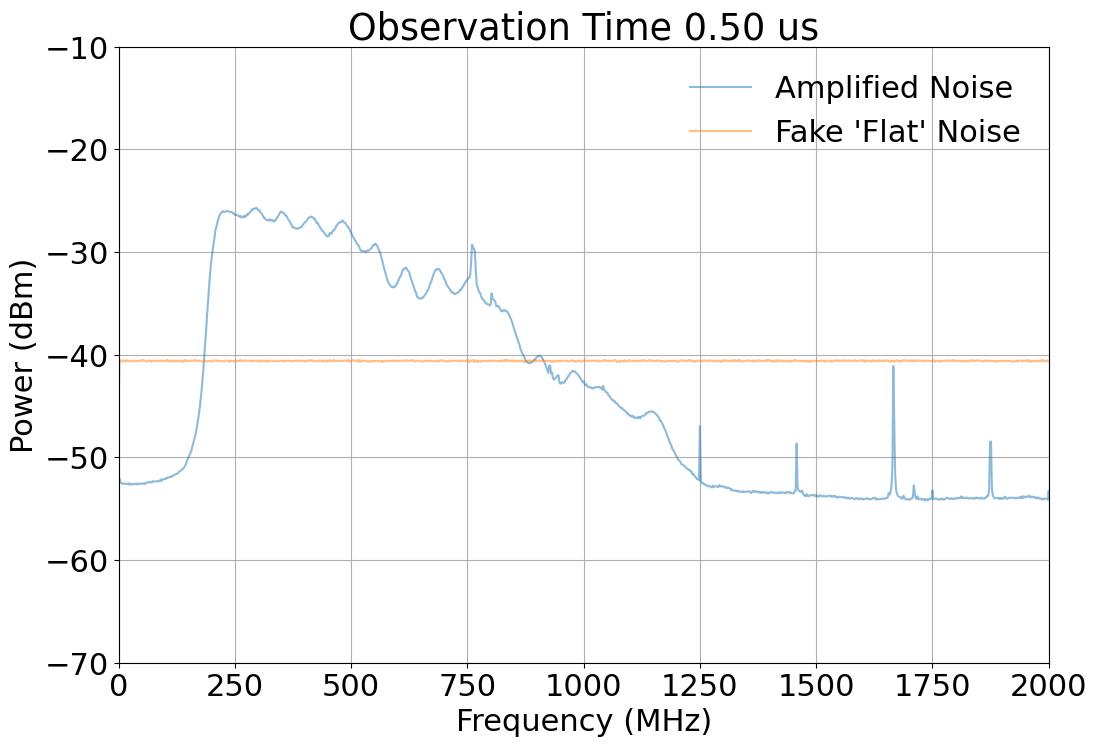

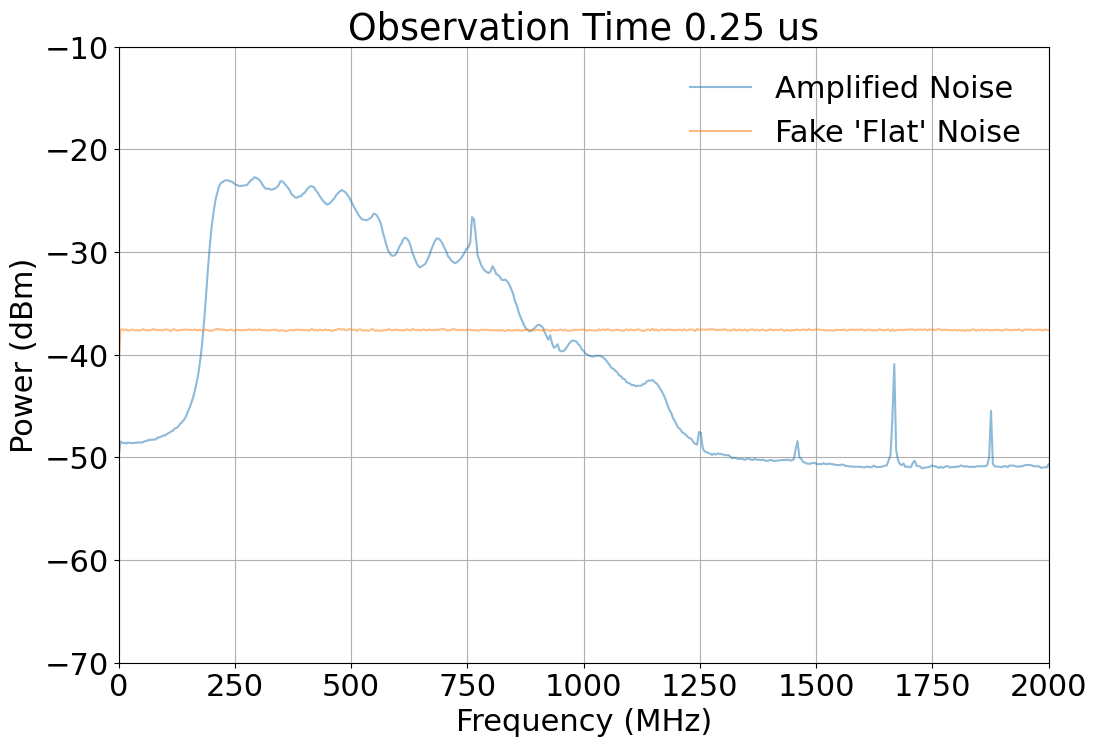

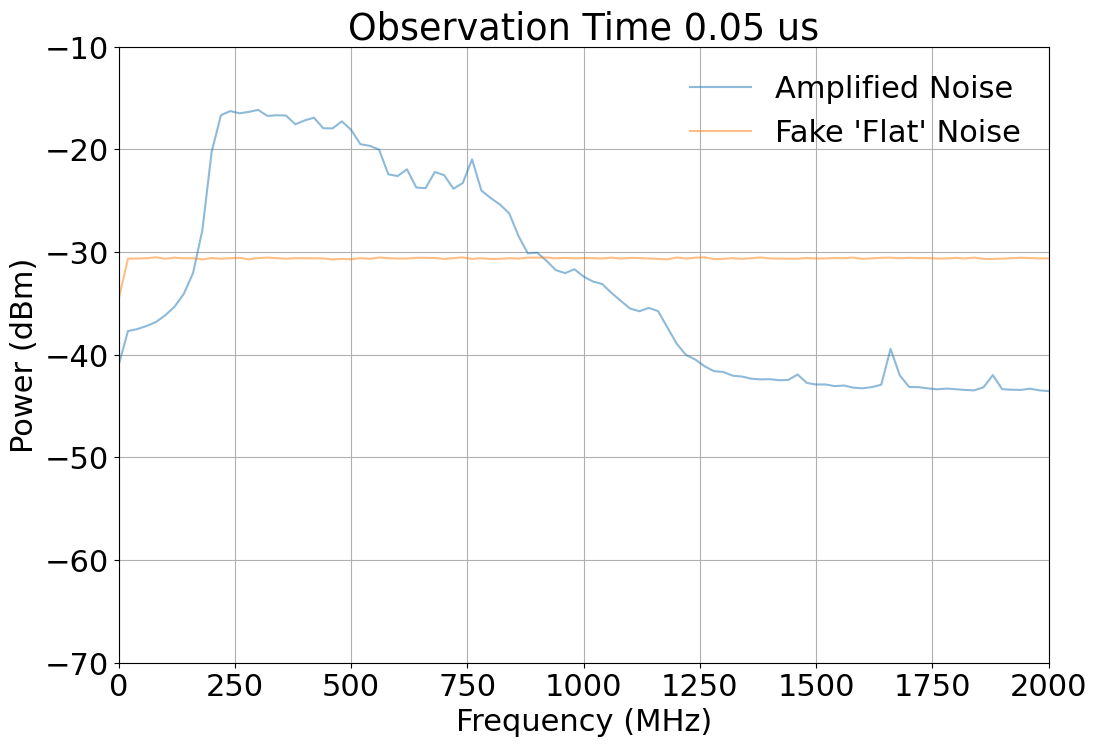

In [46]:
for testN in [10000,5000,1000]:
    print(testN)
    
    nanl=trimAndDownsample(amplifiedNoiseList,0,testN,step)
    ntl=trimAndDownsample(timeList,0,testN,step)
    fnnl=np.random.normal(loc=mu,scale=std,size=nanl.shape)

    print("stds",np.std(nanl),np.std(fnnl))
    
    yNAN = fft(nanl) #FFT of Amplified Noise
    yNFN = fft(fnnl)

    yNANMean=np.mean(np.abs(yNAN),axis=0)
    yNFNMean=np.mean(np.abs(yNFN),axis=0)
    
    nN=np.shape(nanl[0])[0]
    ndt=ntl[1]-ntl[0]
    ndf=1/(nN*ndt)  # Frequency spacing
    nxf = pft.getFrequencyBins(nN,ndt) *1e6
    print(nN,ndt,ndf,nxf[1]-nxf[0])
    fig,ax = plt.subplots()
    ax.plot(nxf/1e6,pft.convertFFTTodBm(yNANMean,50),label="Amplified Noise",alpha=0.5) #1e6 to convert to MHz
    ax.plot(nxf/1e6,pft.convertFFTTodBm(yNFNMean,50),label="Fake 'Flat' Noise",alpha=0.5) #1e6 to convert to MHz
    ax.set_xlabel("Frequency (MHz)")
    ax.set_ylabel("Power (dBm)")
    ax.set_title("Observation Time {:.2f} us".format(nN*ndt))
    #ax.set_yscale('log')
    low,high=ax.get_ylim()
    ax.set_ylim([-70,-10])
    ax.set_xlim([0,2e3])
    ax.legend()
    ax.grid()
    
    idx300=find_nearest_index(nxf/1e6,300)
    print("Noise Power at 300MHz",pft.convertFFTToPower(yNANMean,50)[idx300],"W")
    
    print("Noise Power at 300MHz / Hz",pft.convertFFTToPower(yNANMean,50)[idx300]/(nxf[1]-nxf[0]),"W/Hz")
    

Text(0, 0.5, 'Thermal Noise Power (dBm)')

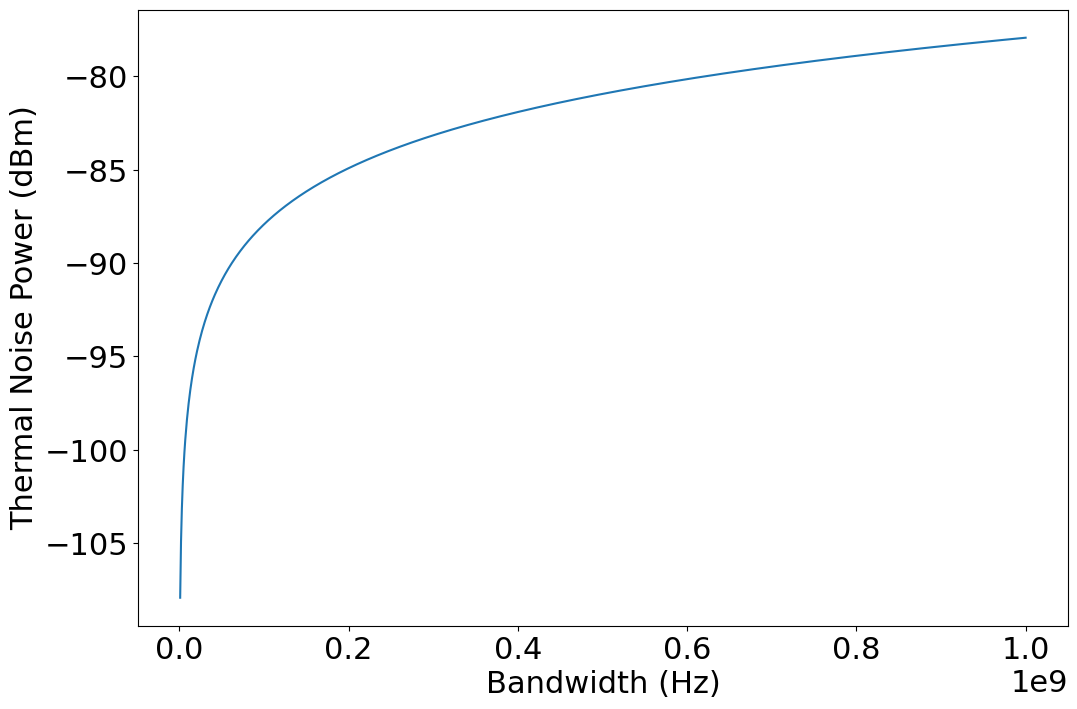

In [10]:
fig, ax = plt.subplots()
bwArr = np.linspace(1e6,1e9,1001)
ax.plot(bwArr,pft.convertPowerTodBm(pft.getNoiseRMS(292,50,bwArr)**2/50))
ax.set_xlabel("Bandwidth (Hz)")
ax.set_ylabel("Thermal Noise Power (dBm)")

## Individual Frequency Bin Distributions
When we perform the (fast) Fourier Transform of a dataset of $N$ samples in the time domain, we obtain $N$ complex numbers in the frequency domain spanning a range of frequencies whihc are commonly referred to a positive and negative frequencies (where the complex Fourier component for the ngative components and the complex conjugate of the positive frequencies (if the input data is real).

For purely thermal noise we expect:
* The power in each frequency bin to be $P = 4 k_B T \Delta f$, with Gaussian power distributions in both the real and imaginary projections.
* The angle in each frequency bin is random for each event.


(10000, 50002)
(50002,)


Text(0.5, 0, 'Sqrt(2) * Real STD - Magntidue')

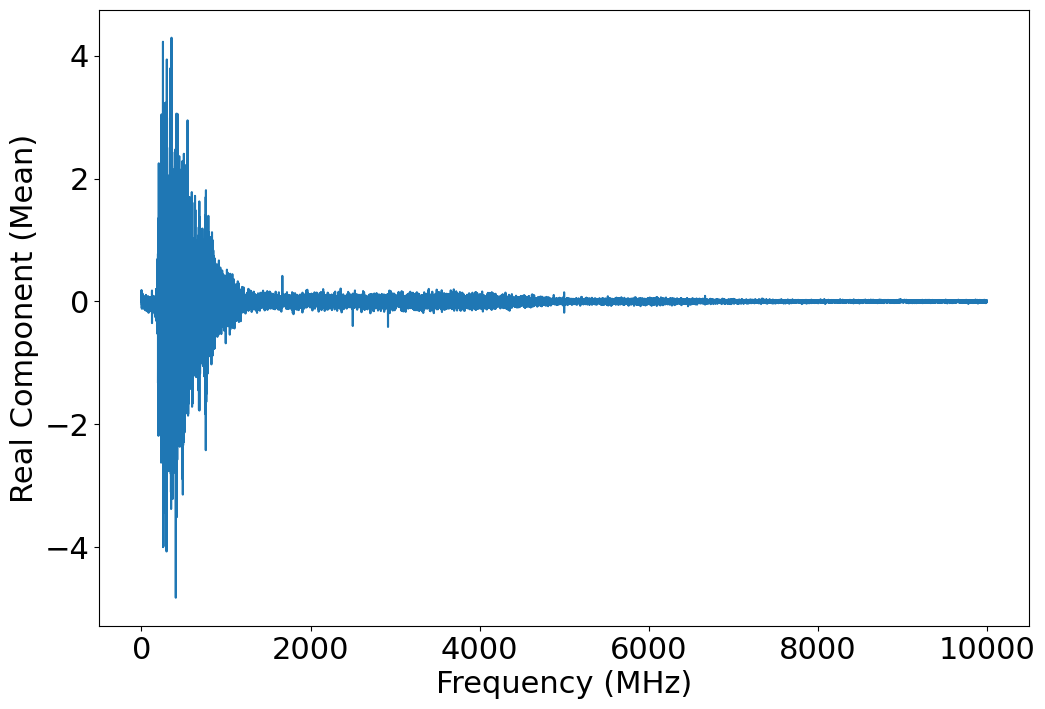

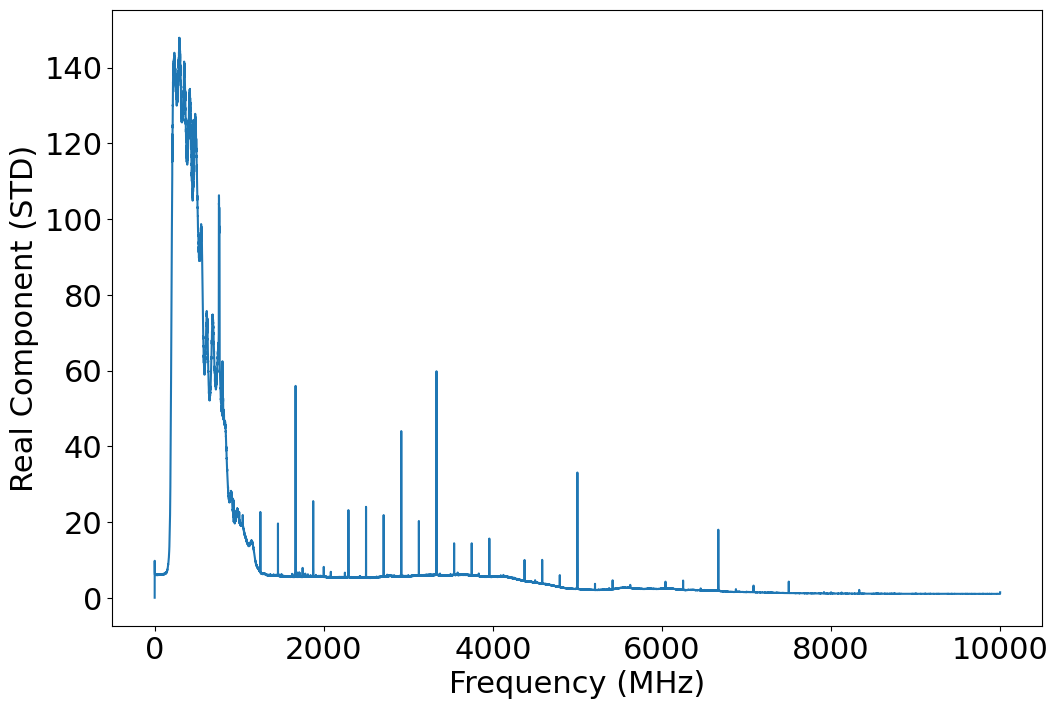

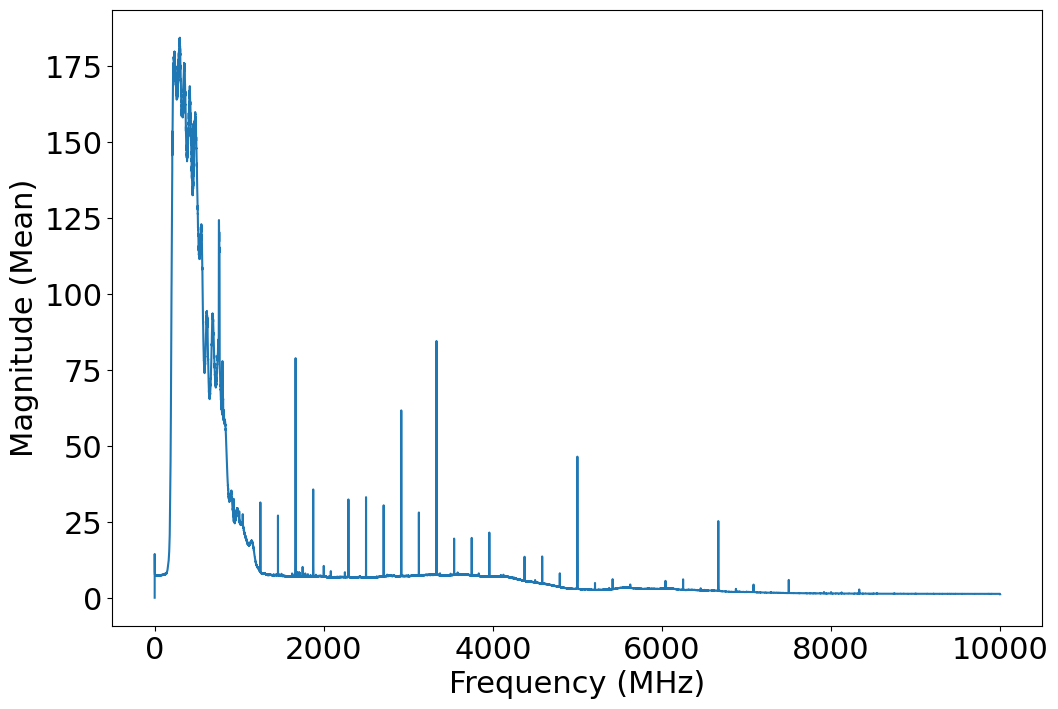

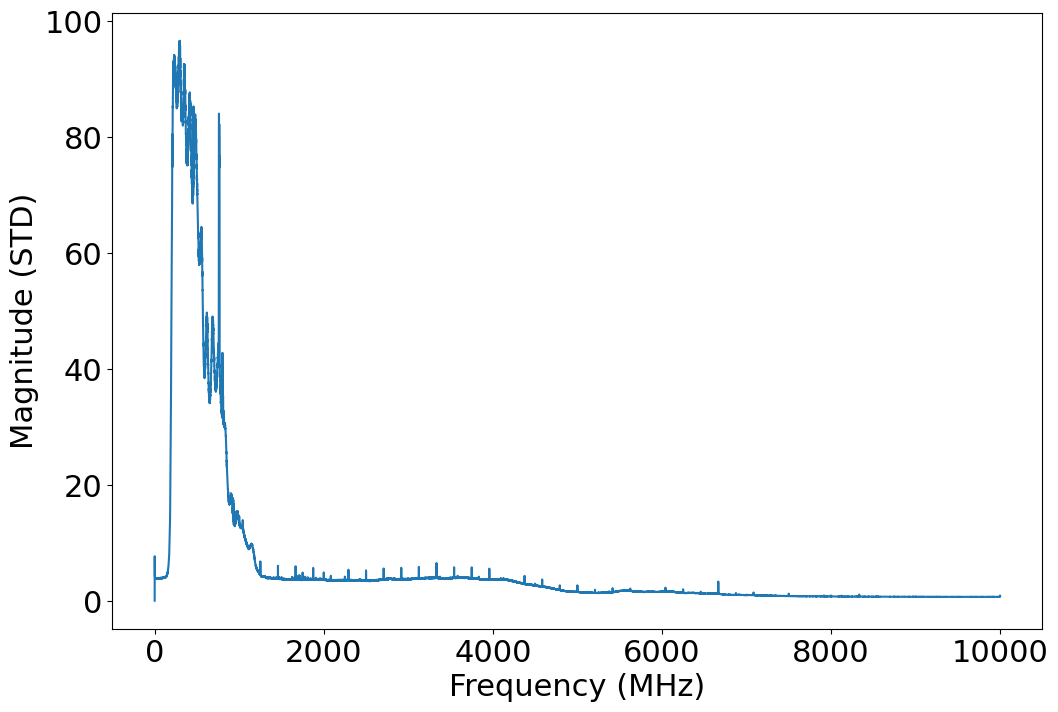

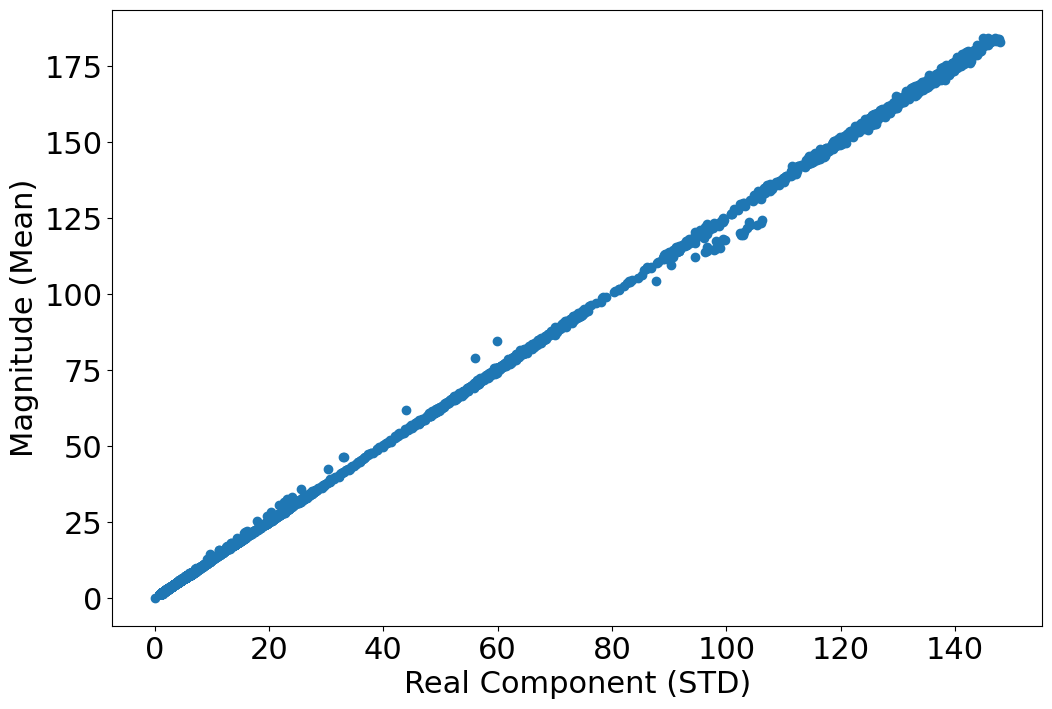

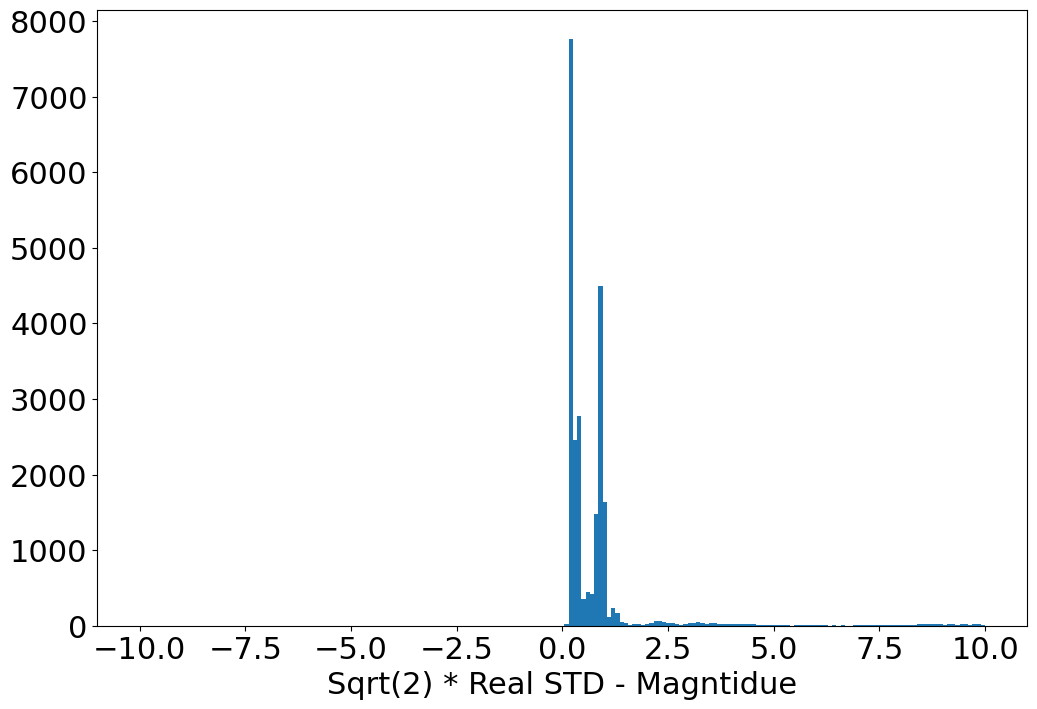

In [11]:
yANReal=np.real(yAN)
yANMag=np.abs(yAN)
print(yANReal.shape)
realMean=np.mean(yANReal,axis=0)
realStd=np.std(yANReal,axis=0)
magMean=np.mean(yANMag,axis=0)
magStd=np.std(yANMag,axis=0)
print(realMean.shape)


fig, ax = plt.subplots()
ax.plot(xf/1e6,realMean[0:len(xf)])
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Real Component (Mean)")

fig, ax = plt.subplots()
ax.plot(xf/1e6,realStd[0:len(xf)])
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Real Component (STD)")


fig, ax = plt.subplots()
ax.plot(xf/1e6,magMean[0:len(xf)])
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Magnitude (Mean)")

fig, ax = plt.subplots()
ax.plot(xf/1e6,magStd[0:len(xf)])
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Magnitude (STD)")


fig, ax = plt.subplots()
ax.scatter(realStd[0:len(xf)],magMean[0:len(xf)])
ax.set_xlabel("Real Component (STD)")
ax.set_ylabel("Magnitude (Mean)")


fig, ax = plt.subplots()
ax.hist(realStd[0:len(xf)]*np.sqrt(2)-magMean[0:len(xf)],bins=np.linspace(-10,10,200))
ax.set_xlabel("Sqrt(2) * Real STD - Magntidue")



(10000, 50002)


(array([ 296.,  531.,  867., 1367., 1979., 2010., 1242.,  818.,  607.,
         283.]),
 array([-6.16749823, -4.92552147, -3.68354472, -2.44156796, -1.19959121,
         0.04238555,  1.28436231,  2.52633906,  3.76831582,  5.01029257,
         6.25226933]),
 <BarContainer object of 10 artists>)

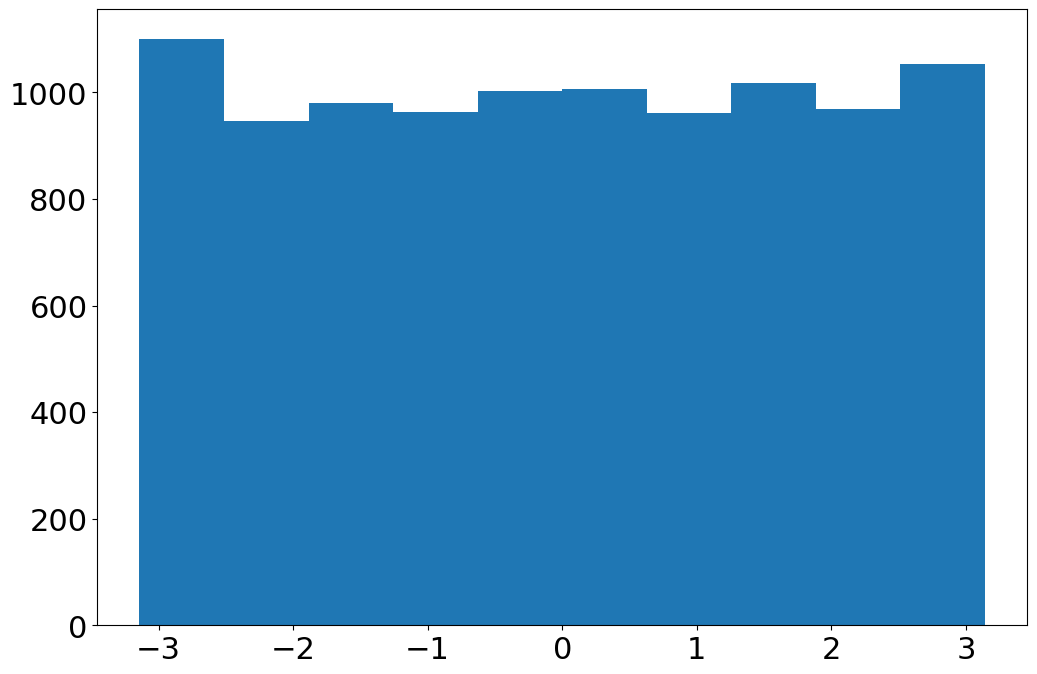

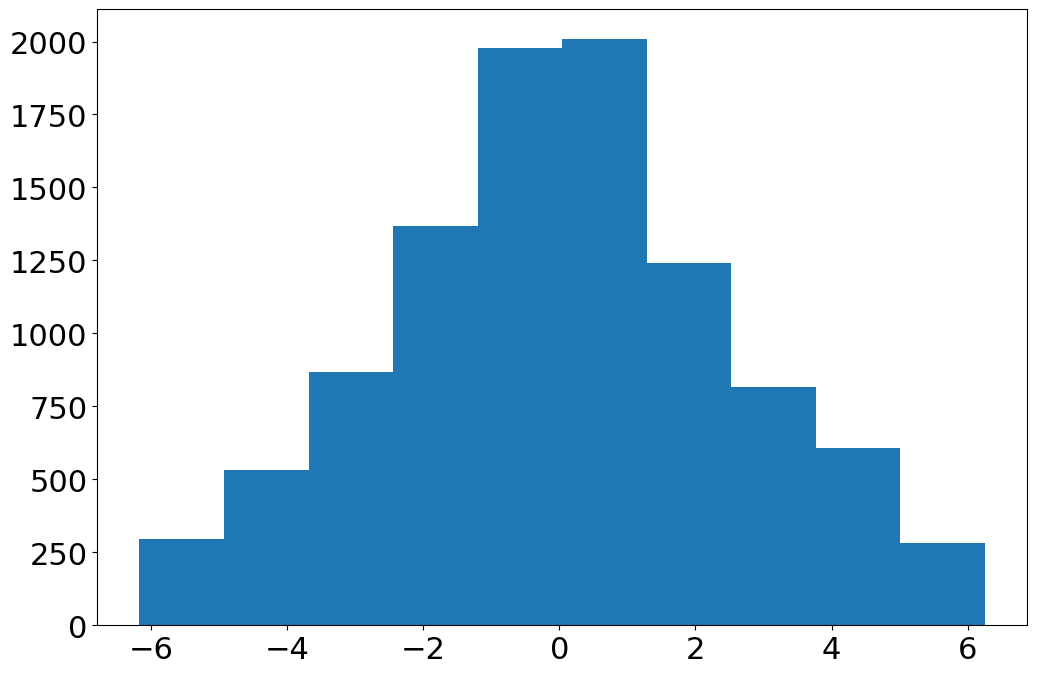

In [12]:
yANAngle=np.angle(yAN)
print(np.shape(yANAngle))
fig, ax = plt.subplots()
ax.hist(yANAngle[:,200])

yANAngleDiff=yANAngle[:,1:]-yANAngle[:,:-1]
fig, ax = plt.subplots()
ax.hist(yANAngleDiff[:,300])

## Calibration Data

Using the network analyser we can measure the response of the RF chain. There are two RF paths of interest.

These are:
* Noise path: 50 Ohm Terminator *** -> Coupler Output -> Cable -> High Pass Filter -> Amplifier -> Low Pass Filter -> Cable ***
* Sine wave path: *** Cable -> Coupler Couple -> Cable -> High Pass Filter -> Amplifier -> Low Pass Filter -> Cable ***
The measurements were made across the chain from *** to ***.

In [13]:
arrNoise = np.loadtxt("caldata/LMNOCOUPLERFNOISE.CSV",delimiter=",", dtype=float,skiprows=3)
arrSine = np.loadtxt("caldata/LMNOCOUPLERSINE.CSV",delimiter=",", dtype=float,skiprows=3)

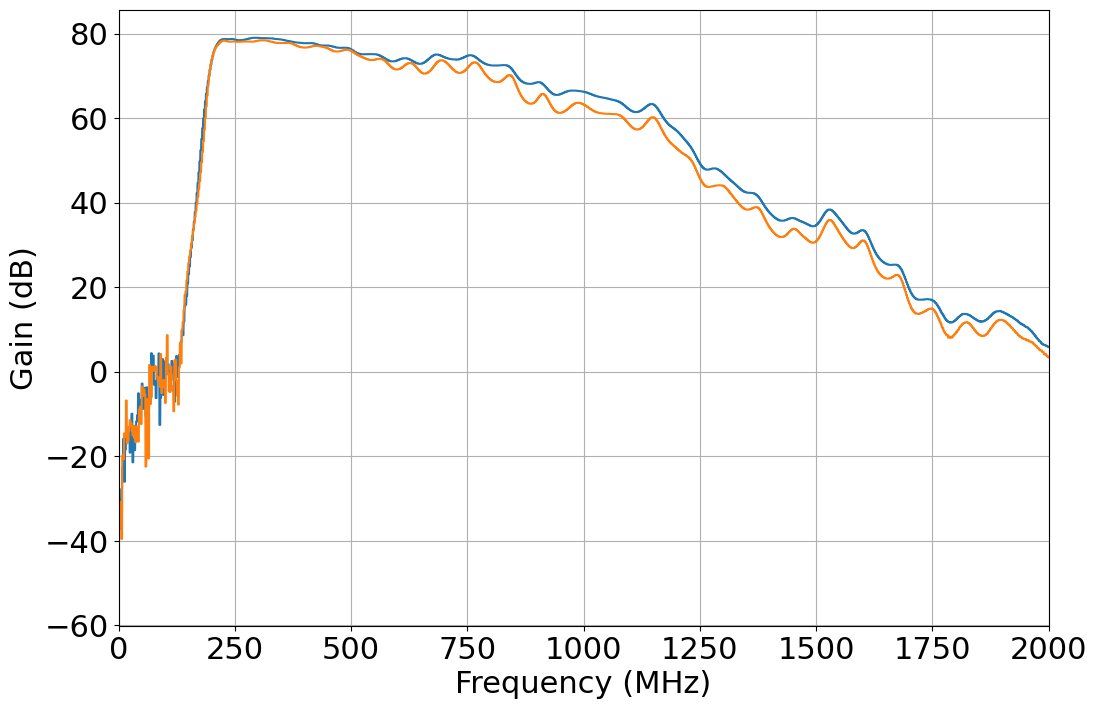

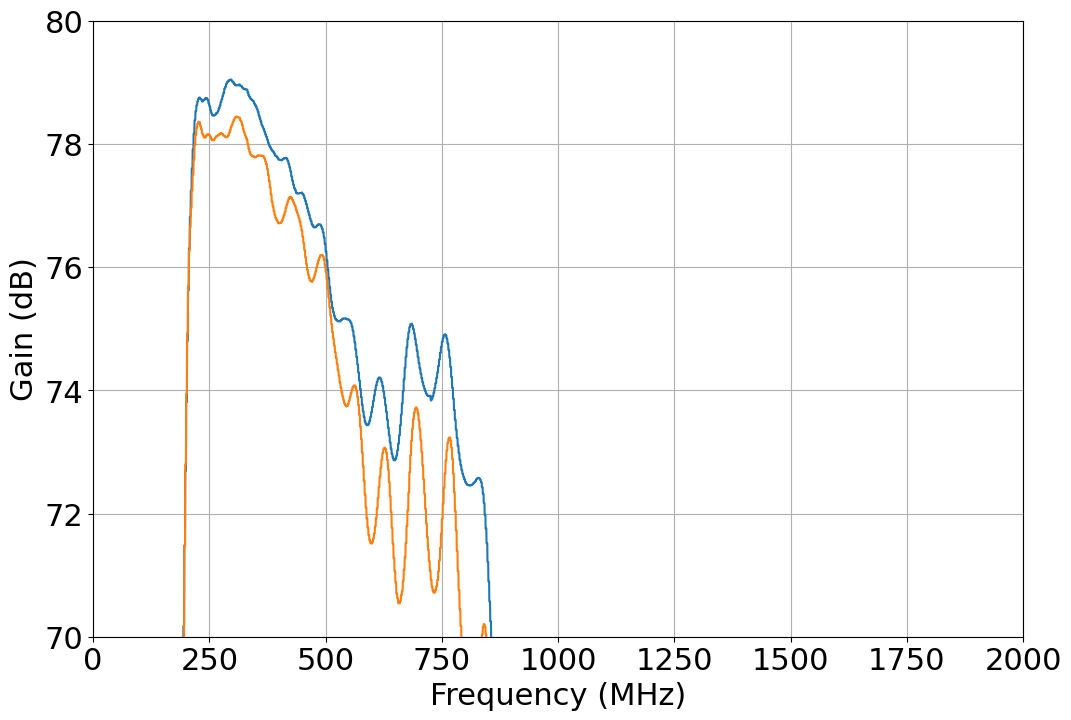

In [14]:
    
gainNoise=pft.convertFrequencyBinning(arrNoise,xf)+63  #For 60dB of attenuation in VNA measurement +3db splitter
gainSine=pft.convertFrequencyBinning(arrSine,xf)+63 #For 60dB of attenuation in VNA measurement +3db splitter


fig, ax = plt.subplots()
ax.plot(xf/1e6,gainNoise)
ax.plot(xf/1e6,gainSine)
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Gain (dB)")
ax.set_xlim([0,2000])
#ax.set_ylim([20,80])
ax.grid()


fig, ax = plt.subplots()
ax.plot(xf/1e6,gainNoise)
ax.plot(xf/1e6,gainSine)
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Gain (dB)")
ax.set_xlim([0,2000])
ax.set_ylim([70,80])
ax.grid()


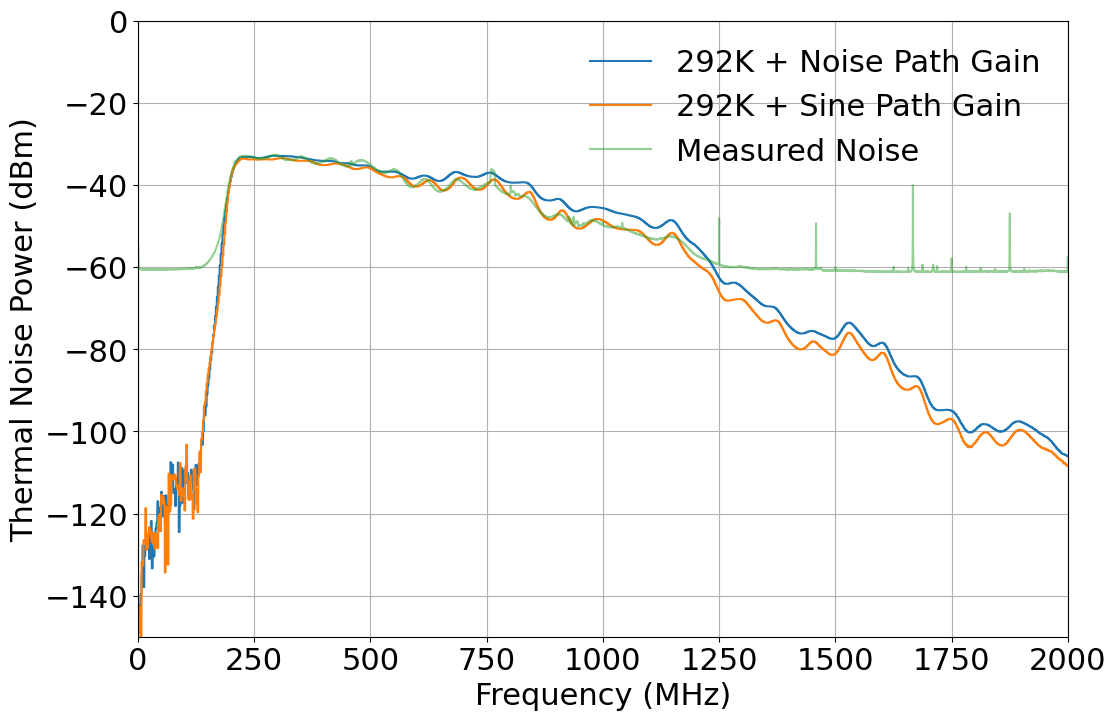

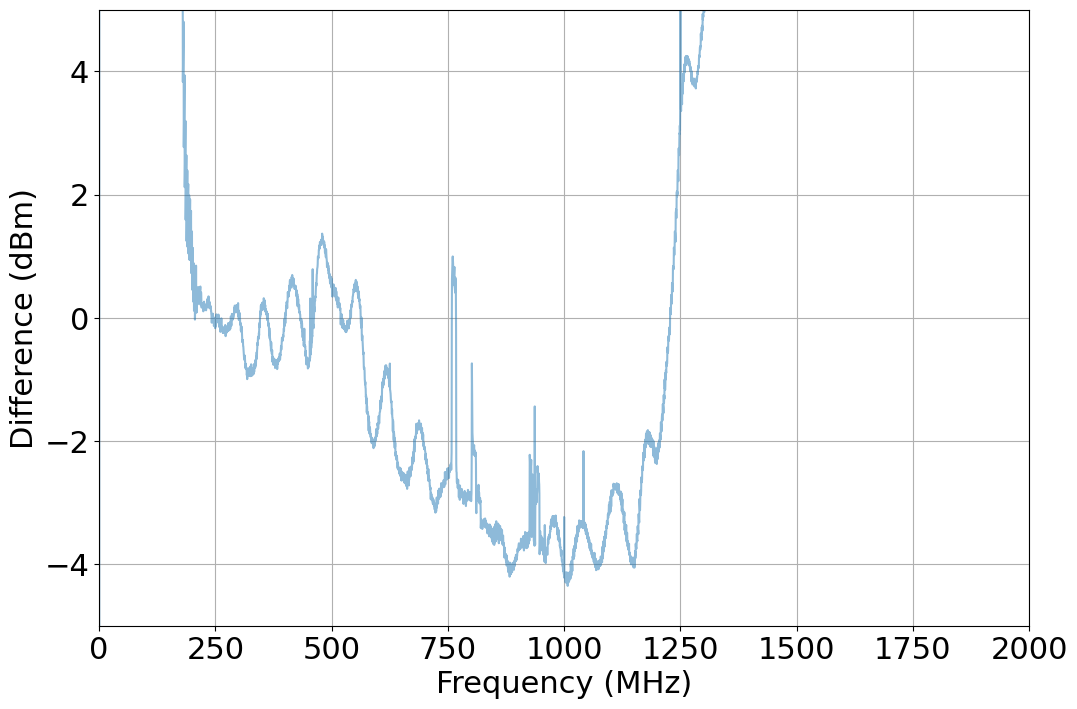

In [15]:
#Trying to model thermal noise
#T=292K,R=50Ohm,bandwdith of single bin
noiseLevel=np.ones(xf.shape)*pft.convertPowerTodBm(pft.getNoiseRMS(292,50,(xf[1]-xf[0]))**2/50)
noiseLevelSine=noiseLevel+gainSine
noiseLevel=noiseLevel+gainNoise


fig, ax = plt.subplots()
ax.plot(xf/1e6,noiseLevel,label="292K + Noise Path Gain")
ax.plot(xf/1e6,noiseLevelSine,label="292K + Sine Path Gain")
ax.plot(xf/1e6,pft.convertFFTTodBm(yANMean,50),label="Measured Noise",alpha=0.5) #1e6 to convert to MHz
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Thermal Noise Power (dBm)")
ax.set_xlim([0,2000])
ax.set_ylim([-150,0])
ax.legend()
ax.grid()


fig, ax = plt.subplots()
ax.plot(xf/1e6,pft.convertFFTTodBm(yANMean,50)-noiseLevel,label="Amplified Noise",alpha=0.5) #1e6 to convert to MHz
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Difference (dBm)")
ax.set_xlim([0,2000])
ax.set_ylim([-5,5])
ax.grid()